<a href="https://colab.research.google.com/github/advapplab/sentiment_analysis_election_2022/blob/main/predict_unlabelled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

In [ ]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 19.2 MB/s 
     |████████████████████████████████| 212 kB 56.5 MB/s 
     |████████████████████████████████| 182 kB 68.2 MB/s 
     |████████████████████████████████| 132 kB 63.1 MB/s 
     |████████████████████████████████| 127 kB 60.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 21.0 MB/s 
     |████████████████████████████████| 7.6 MB 62.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.8 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Unins

In [ ]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-bert-wwm"

if number_classes == 2:
    model_classifier = "owen198/weibo-wmmbert-2"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [ ]:
model_classifier

'owen198/weibo-wmmbert-2'

# 1. load and clean data

In [ ]:
#insert new xlsx file here
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/df_sample.xlsx

--2022-12-08 01:16:19--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/df_sample.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111029 (108K) [application/octet-stream]
Saving to: ‘df_sample.xlsx’

df_sample.xlsx      100%[===================>] 108.43K  --.-KB/s    in 0.002s  

2022-12-08 01:16:19 (68.5 MB/s) - ‘df_sample.xlsx’ saved [111029/111029]



In [ ]:
import pandas as pd

In [ ]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/df_sample.xlsx')

testing_pd = testing_pd[['text']]

In [ ]:
#dirty data
testing_pd

,text
0,【谈北市选战三脚督柯文哲点出“2情况”：蓝绿都投黄珊珊】九合一选举年底登场，台北市长选战“三...
1,【黄珊珊民调反超陈时中、威胁蒋万安？ 郭正亮：关键在这群人】对于有台北市长选举民调显示，蒋万...
2,【台北市长选战若三脚督 阿扁最新预测：这人恐被弃保】台北市长选战，民进党参选人陈时中、国民党...
3,【这家民调蒋万安拉警报？ 郭正亮惊爆内幕：帮陈时中冲喜】对于《东森新闻》委托“雨晴民调公司”...
4,"【陈时中称蒋万安防疫主张抄袭自己 蒋万安：他防疫做得这么差 谁会想抄】<a href=""h..."
...,...
195,中國國民黨台北市長參選人蔣萬安選情始終無法拉開，泛藍基本盤未歸隊是主因。前立法院長王金平上周...
196,【外传绿下周征召陈时中选台北市 蒋万安呛：任何个人决定都不该影响防疫】国民党台北市长参选人蒋...
197,【周玉蔻怎能霸占黄金时段？郭正亮爆：被“有分量”金主标下】资深媒体人周玉蔻日前攻击国民党台北...
198,额？？？这是蒋万安的竞选团队？？？


In [ ]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
#if you wish to preserve the titles. replace the corresponding block of code below with this one 

#testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True)#.replace(title_pattern_1,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
##testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
#________________________________________________________________________________________________________________________

testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]


import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'

#replace with this block. Do some more research because it looks like some titles are still removed, like index 41
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)

<ipython-input-9-67f978a2f233>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
<ipython-input-9-67f978a2f233>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
<ipython-input-9-67f978a2f233>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [ ]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text
0,九合一选举年底登场，台北市长选战“三脚督”态势明显，现任市长柯文哲今分析指出，国民党参选人蒋...
1,对于有台北市长选举民调显示，蒋万安冲到39％，黄珊珊24％，陈时中18％。民众党台北市议员参...
2,台北市长选战，民进党参选人陈时中、国民党参选人蒋万安、民众党支持的台北市副市长黄珊珊等3人，...
3,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...
4,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...
...,...
185,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...
186,中國國民黨台北市長參選人蔣萬安選情始終無法拉開，泛藍基本盤未歸隊是主因。前立法院長王金平上周...
187,国民党台北市长参选人蒋万安今早前往“本命区”中山区文昌宫参拜，许多蓝营里长陪同在侧，对于传言...
188,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...


## 1-2 Tokenization

In [ ]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
full_test_dataset = tokenized_datasets["test"]

# 2. preparing BERT


In [ ]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

Downloading:   0%|          | 0.00/909 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-17-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
import numpy as np

#prediction results


In [ ]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 190
  Batch size = 8


In [ ]:
pred

PredictionOutput(predictions=array([[ 1.6333476 , -2.109077  ],
       [-1.8040097 ,  1.7588148 ],
       [-1.9969735 ,  2.0646303 ],
       [ 2.0315373 , -2.6380613 ],
       [ 1.7843024 , -2.3534229 ],
       [ 2.1272569 , -2.745603  ],
       [ 1.0068092 , -0.3195643 ],
       [ 1.9081945 , -2.5041852 ],
       [ 2.2389355 , -2.9100974 ],
       [-0.16411772,  0.49444088],
       [ 1.7203926 , -2.260766  ],
       [-2.2002497 ,  2.327979  ],
       [-2.2814538 ,  2.4072645 ],
       [ 2.19233   , -2.8309178 ],
       [ 2.352627  , -3.3197083 ],
       [ 0.445921  ,  0.07042871],
       [-2.227416  ,  2.3561804 ],
       [ 2.1728144 , -2.803353  ],
       [-2.476833  ,  2.5558677 ],
       [ 1.9952608 , -2.5990412 ],
       [ 2.0986528 , -2.712181  ],
       [-2.5946174 ,  2.6294172 ],
       [ 2.4960227 , -3.711701  ],
       [-1.9568508 ,  2.0052    ],
       [ 2.014571  , -2.6197405 ],
       [ 2.1429958 , -2.7647827 ],
       [ 2.2662382 , -2.9734201 ],
       [-2.3283253 ,  2.44

In [ ]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0])

In [ ]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [ ]:
#final table. Remember, 0 = negative, 1 = positive
testing_pd

,text,pred
0,九合一选举年底登场，台北市长选战“三脚督”态势明显，现任市长柯文哲今分析指出，国民党参选人蒋...,0
1,对于有台北市长选举民调显示，蒋万安冲到39％，黄珊珊24％，陈时中18％。民众党台北市议员参...,1
2,台北市长选战，民进党参选人陈时中、国民党参选人蒋万安、民众党支持的台北市副市长黄珊珊等3人，...,1
3,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0
4,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...,0
...,...,...
185,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,1
186,中國國民黨台北市長參選人蔣萬安選情始終無法拉開，泛藍基本盤未歸隊是主因。前立法院長王金平上周...,1
187,国民党台北市长参选人蒋万安今早前往“本命区”中山区文昌宫参拜，许多蓝营里长陪同在侧，对于传言...,1
188,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...,0


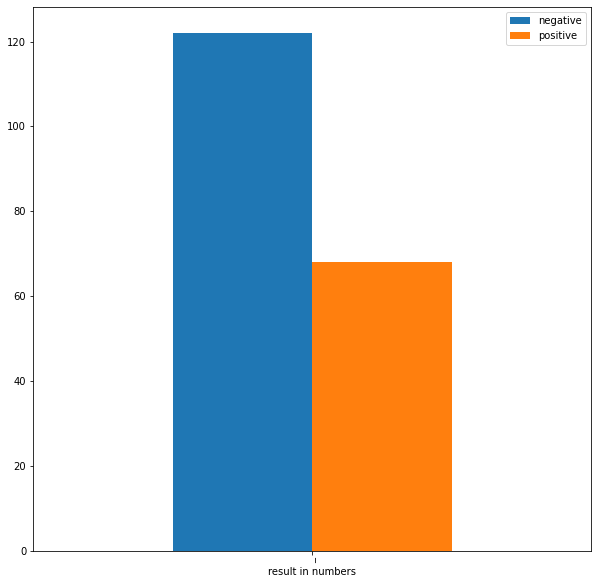

In [ ]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
count0 = (testing_pd['pred'] == 0).sum()
count1 = (testing_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[count0], 'positive': [count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

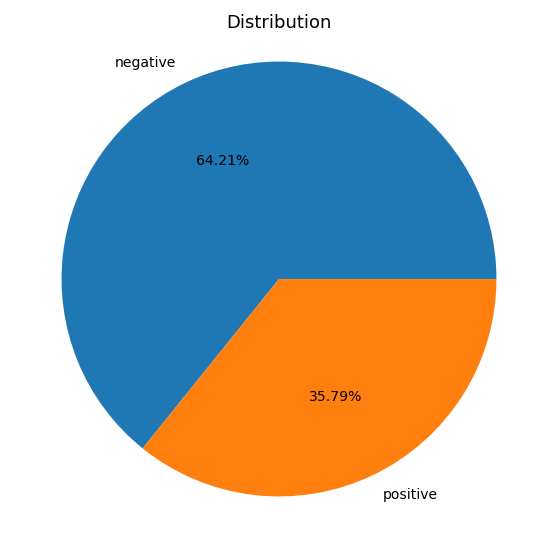

In [ ]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

per1=Percentage(count0, count1)
per2=Percentage(count1, count0)

label = ['negative', 'positive']
shares = [per1, per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(shares, labels=label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Distribution', fontsize=18, y=0.95);